In [1]:
import wandb
import numpy as np
import sys
import torch
import torch.utils.data as Data
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import torch.nn as nn
import glob
import xarray as xr
import matplotlib.pyplot as plt


BASE = '/scratch/ab10313/pleiades/'
PATH_NN= BASE+'NN_data_smooth/'
save_path=BASE+"trained_models"


import submeso_ml.systems.regression_system as regression_system
import submeso_ml.models.fcnn as fcnn
import submeso_ml.data.dataset as dataset



In [2]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Not Available


In [3]:
PATH_LIST_full = glob.glob(BASE+'*_smooth/preprcossed_data/')

In [4]:
PATH_LIST_full

['/scratch/ab10313/pleiades/15_bengal_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/12_agulhas_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/11_new_zealand_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/08_kuroshio_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/10_north_pacific_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/04_equator_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/01_gulf_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/03_south_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/05_argentina_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/13_australia_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/06_california_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/14_indian_ocean_smooth/preprcossed_data/']

In [5]:
label_list = ['Arabian Sea','Agulhas Current', 'New Zealand', 'Kuroshio Current', 'North Pacific', 'Equatorial Atlantic',
              'Gulf Stream', 'South Atlantic', 'Malvinas Current', 'South Pacific', 'California Current','Indian Ocean' ]


# prediction and target by location

## Resolution R^2

In [6]:
#r2_param_loc = np.load('/scratch/ab10313/pleiades/trained_models/r2_param_loc_tmp.npy')
#r2_cnn_loc = np.load('/scratch/ab10313/pleiades/trained_models/r2_cnn_loc_tmp.npy')

r2_param_monthly_mean = np.load('/scratch/ab10313/pleiades/trained_models/r2_param_monthly_mean.npy')
r2_cnn_monthly_mean = np.load('/scratch/ab10313/pleiades/trained_models/r2_cnn_monthly_mean.npy')

In [12]:
r2_param_total_mean_loc = np.mean(r2_param_monthly_mean,2)
r2_cnn_total_mean_loc = np.mean(r2_cnn_monthly_mean,2)

In [13]:
# sort by latitude

lat_rad = np.empty(12)
PATH_LIST = glob.glob(BASE+'*_smooth/preprcossed_data/lat.nc')
i_lat_path = 0

for i_lat in range(12):
    #if i_lat == 1 or i_lat ==10 or i_lat ==11:
    #    lat_rad[i_lat] = np.NaN
    #else:
    #    print(i_lat_path)
        lat_rad[i_lat] = xr.open_dataarray(PATH_LIST[i_lat]).values.mean()
    #    i_lat_path = i_lat_path+1
    
    
lat_rad_sorted = np.sort(lat_rad)[::-1]
lat_ind_sorted = np.argsort(lat_rad)[::-1]


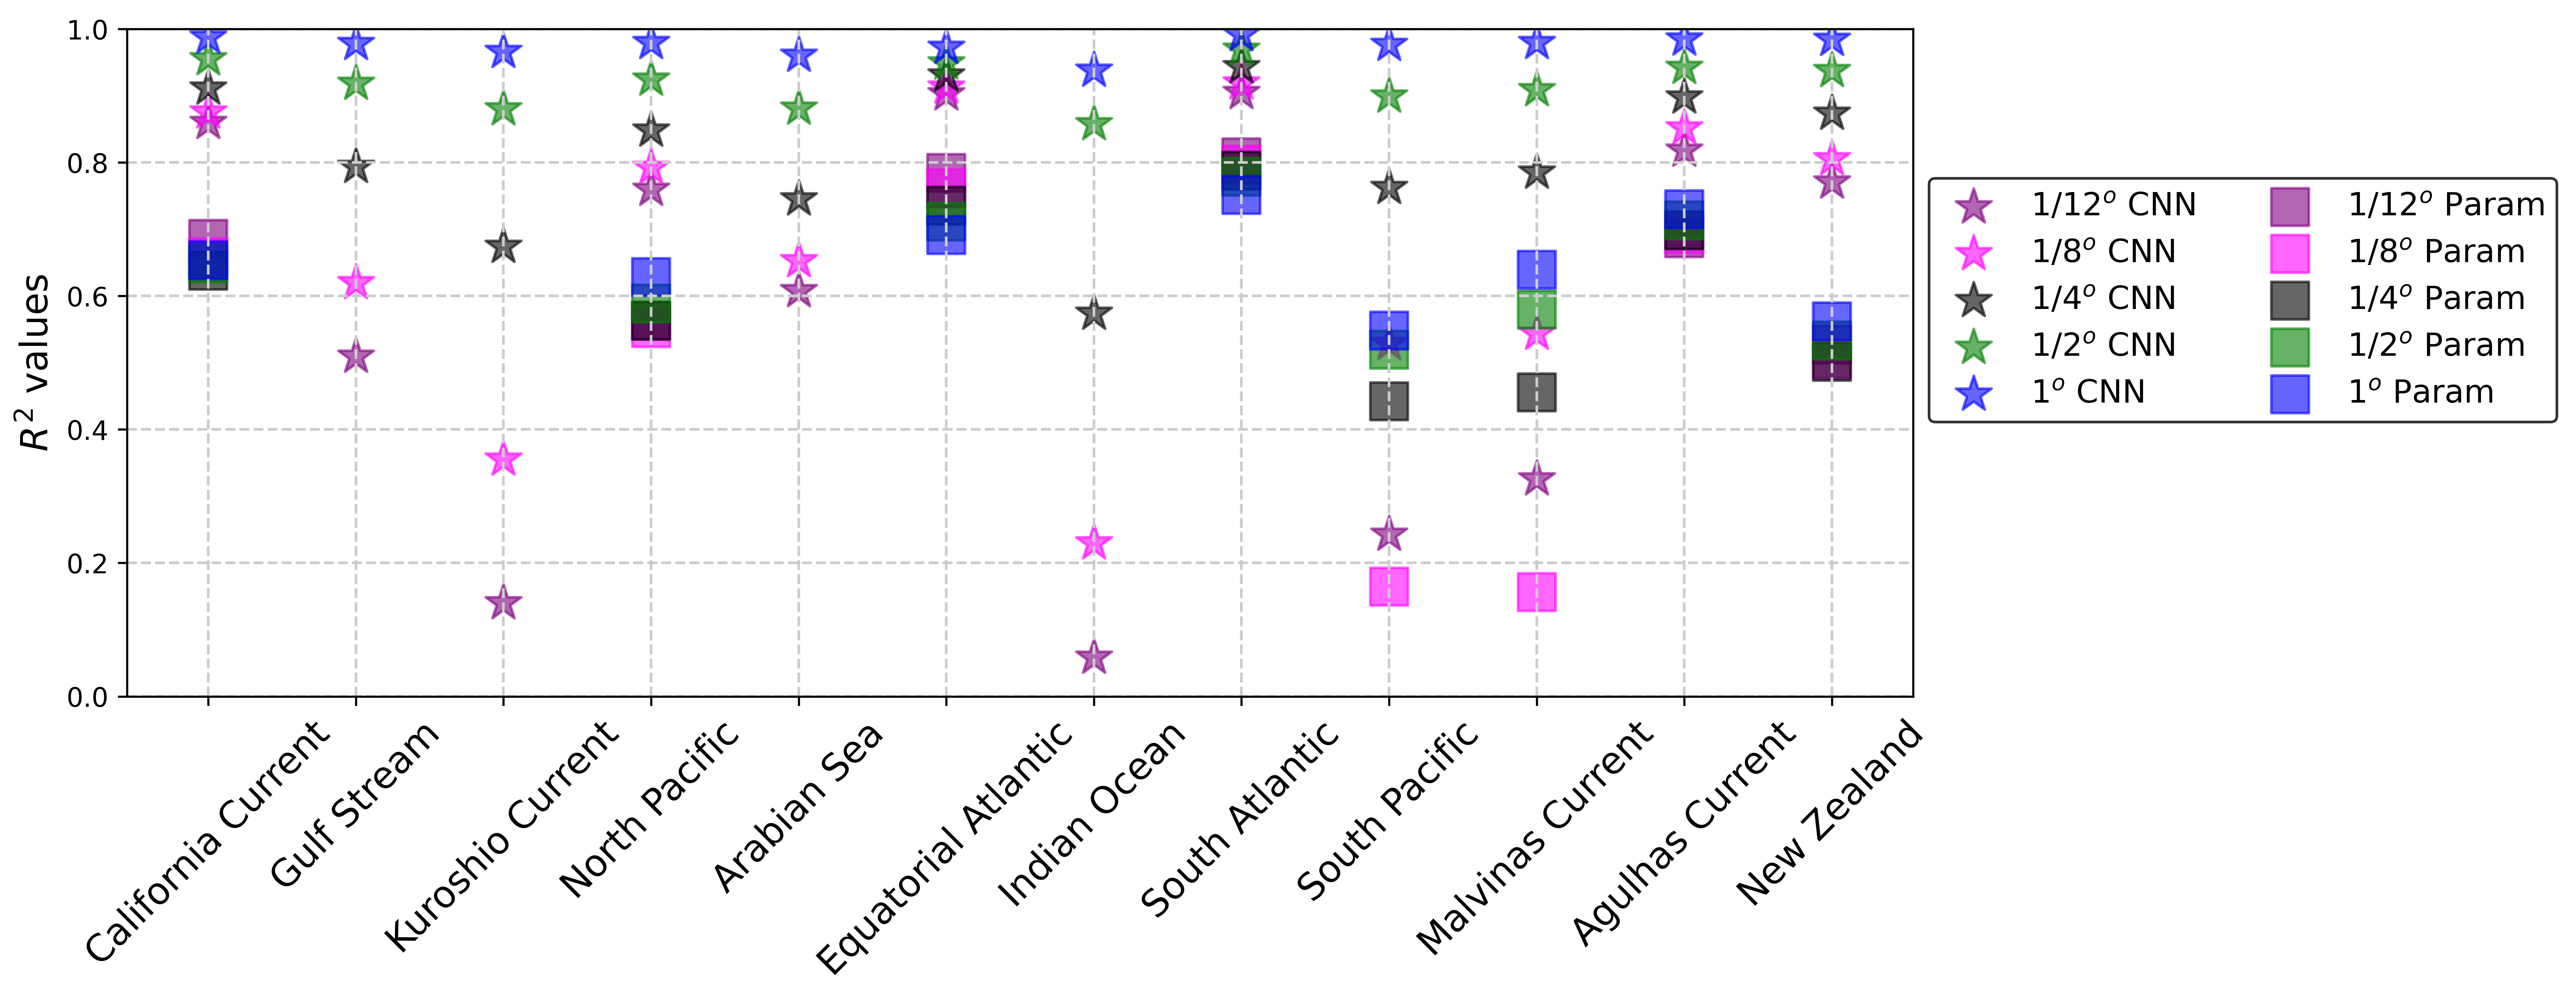

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12,6),dpi=600)
fig.tight_layout(pad=8.0)
plt.rcParams.update({'font.size': 14})

plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)
plt.scatter(range(12),r2_cnn_total_mean_loc[0,lat_ind_sorted],s=200,c= 'purple',marker='*',alpha=0.6,label='$1/12^o$ CNN')
plt.scatter(range(12),r2_cnn_total_mean_loc[1,lat_ind_sorted],s=200,c='magenta',marker='*',alpha=0.6,label='$1/8^o$ CNN')
plt.scatter(range(12),r2_cnn_total_mean_loc[2,lat_ind_sorted],s=200,c='k',marker='*',alpha=0.6,label='$1/4^o$ CNN')
plt.scatter(range(12),r2_cnn_total_mean_loc[3,lat_ind_sorted],s=200,c='green',marker='*',alpha=0.6,label='$1/2^o$ CNN')
plt.scatter(range(12),r2_cnn_total_mean_loc[4,lat_ind_sorted],s=200,c='blue',marker='*',alpha=0.6,label='$1^o$ CNN')

plt.scatter(range(12),r2_param_total_mean_loc[0,lat_ind_sorted],s=200,c= 'purple',marker='s',alpha=0.6,label='$1/12^o$ Param')
plt.scatter(range(12),r2_param_total_mean_loc[1,lat_ind_sorted],s=200,c='magenta',marker='s',alpha=0.6,label='$1/8^o$ Param')
plt.scatter(range(12),r2_param_total_mean_loc[2,lat_ind_sorted],s=200,c='k',marker='s',alpha=0.6,label='$1/4^o$ Param')
plt.scatter(range(12),r2_param_total_mean_loc[3,lat_ind_sorted],s=200,c='green',marker='s',alpha=0.6,label='$1/2^o$ Param')
plt.scatter(range(12),r2_param_total_mean_loc[4,lat_ind_sorted],s=200,c='blue',marker='s',alpha=0.6,label='$1^o$ Param')
my_xticks = [label_list[i] for i in lat_ind_sorted] 
plt.xticks(np.arange(len(label_list)), my_xticks,rotation = 45,fontsize=14);
#plt.xticks(np.arange(len(label_list)), label_list,rotation = 45, fontsize=12);
plt.ylabel('$R^2$ values', fontsize=14)
plt.ylim([0,1])
#plt.legend(fontsize=12,bbox_to_anchor=(0.06, 1),ncol=5).get_frame().set_edgecolor('k')
plt.legend(fontsize=12,bbox_to_anchor=(1.0, .8),ncol=2).get_frame().set_edgecolor('k')


plt.savefig('./figures/r2_resolution_from_monthly_mean',bbox_inches = 'tight')

## split into summer and winter

In [48]:
JAS_ind = [6,7,8]
JFM_ind = [0,1,2]

r2_cnn_summer_loc = np.zeros((5,1))
r2_cnn_winter_loc = np.zeros((5,12))
r2_param_summer_loc = np.zeros((5,12))
r2_param_winter_loc = np.zeros((5,12))

for i_loc in range(12):
        # northern hemisphere
            if i_loc==3 or i_loc==4 or i_loc==6 or i_loc==10:
                r2_cnn_summer_loc[:,i_loc] = np.mean(np.roll(r2_cnn_monthly_mean[:,i_loc,:],-3,axis=1)[:,JAS_ind],1)
                r2_cnn_winter_loc[:,i_loc] = np.mean(np.roll(r2_cnn_monthly_mean[:,i_loc,:],-3,axis=1)[:,JFM_ind],1)
                r2_param_summer_loc[:,i_loc] = np.mean(np.roll(r2_param_monthly_mean[:,i_loc,:],-3,axis=1)[:,JAS_ind],1)
                r2_param_winter_loc[:,i_loc] = np.mean(np.roll(r2_param_monthly_mean[:,i_loc,:],-3,axis=1)[:,JFM_ind],1) 
        # southern hemisphere
            elif i_loc==1 or i_loc==2 or i_loc==7 or i_loc==8 or i_loc==9:
                r2_cnn_summer_loc[:,i_loc] = np.mean(np.roll(r2_cnn_monthly_mean[:,i_loc,:],-3,axis=1)[:,JFM_ind],1)
                r2_cnn_winter_loc[:,i_loc] = np.mean(np.roll(r2_cnn_monthly_mean[:,i_loc,:],-3,axis=1)[:,JAS_ind],1)
                r2_param_summer_loc[:,i_loc] = np.mean(np.roll(r2_param_monthly_mean[:,i_loc,:],-3,axis=1)[:,JFM_ind],1)
                r2_param_winter_loc[:,i_loc] = np.mean(np.roll(r2_param_monthly_mean[:,i_loc,:],-3,axis=1)[:,JAS_ind],1) 


In [49]:
r2_cnn_param_summer = np.zeros((5,24))
r2_cnn_param_summer[:,::2] = r2_cnn_summer_loc[:,lat_ind_sorted]
r2_cnn_param_summer[:,1::2] = r2_param_summer_loc[:,lat_ind_sorted]

r2_cnn_param_winter = np.zeros((5,24))
r2_cnn_param_winter[:,::2] = r2_cnn_winter_loc[:,lat_ind_sorted]
r2_cnn_param_winter[:,1::2] = r2_param_winter_loc[:,lat_ind_sorted]

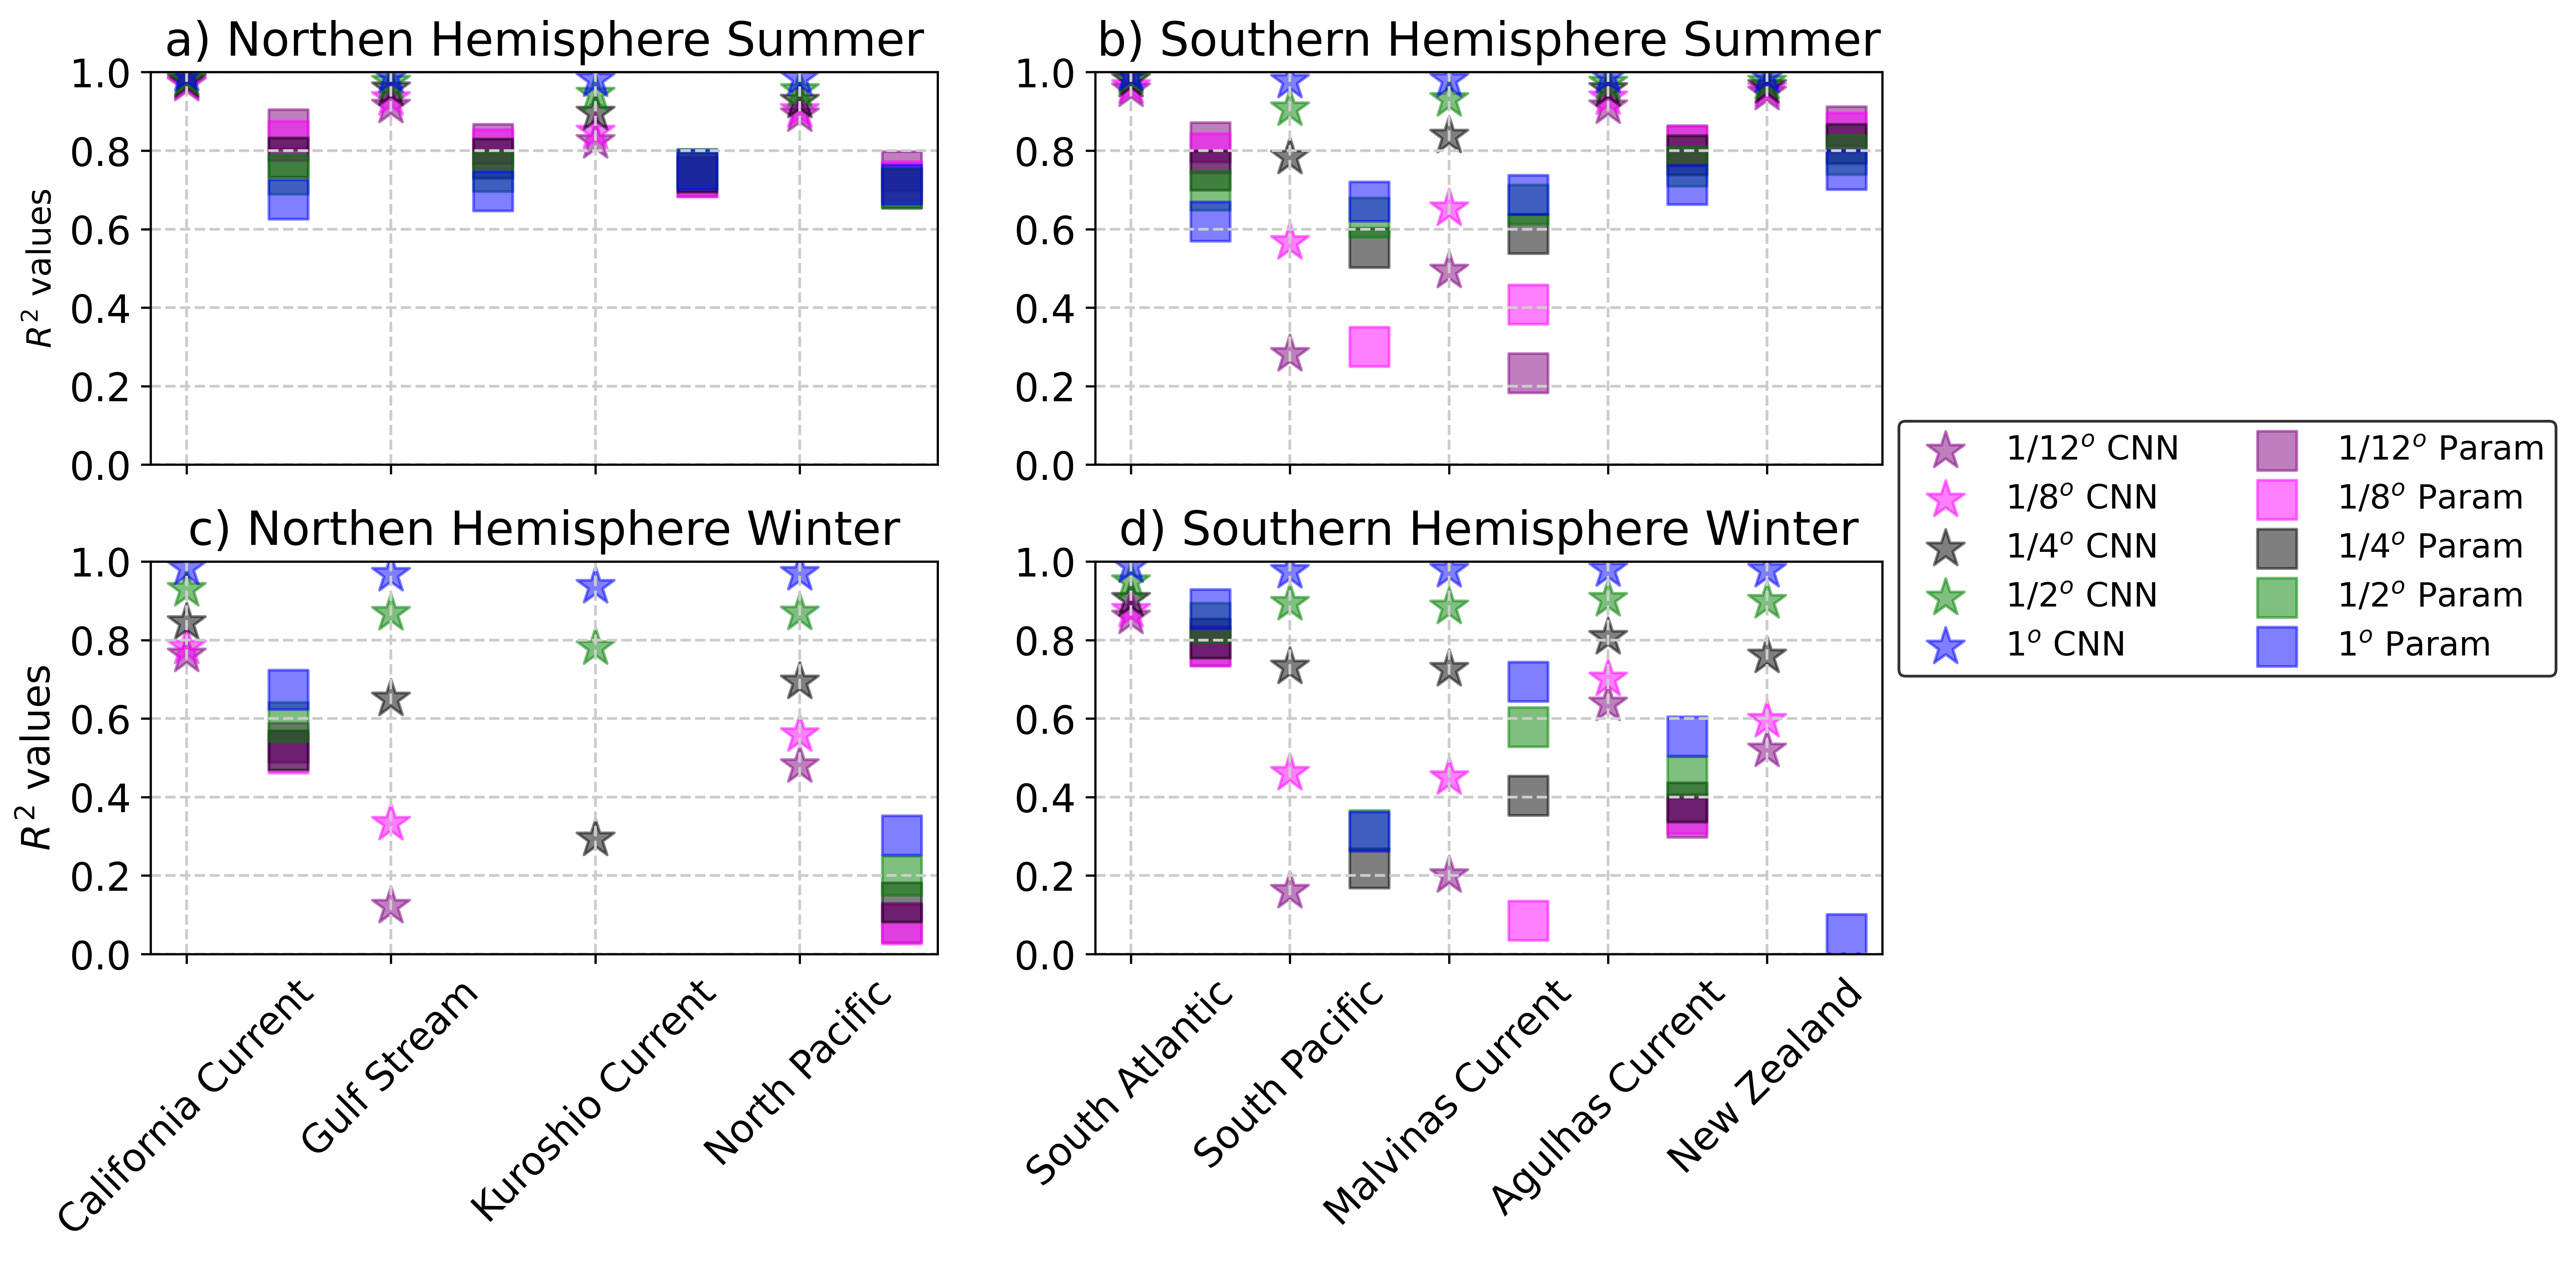

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,8),dpi=600)
fig.tight_layout(pad=2.0)
plt.rcParams.update({'font.size': 14})

plt.subplot(3,2,1)
plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)

plt.scatter(range(24)[::2][:4],r2_cnn_param_summer[0,::2][:4],s=200,marker='*',color= 'purple', alpha=0.5,label='$1/12^o$ CNN')
plt.scatter(range(24)[1::2][:4],r2_cnn_param_summer[0,1::2][:4],s=200,marker='s',color= 'purple', alpha=0.5,label='$1/12^o$ Param')

plt.scatter(range(24)[::2][:4],r2_cnn_param_summer[1,::2][:4],s=200,marker='*',color='magenta',alpha=0.5,label='$1/8^o$ CNN')
plt.scatter(range(24)[1::2][:4],r2_cnn_param_summer[1,1::2][:4],s=200,marker='s',color='magenta',alpha=0.5,label='$1/8^o$ Param')


plt.scatter(range(24)[::2][:4],r2_cnn_param_summer[2,::2][:4],s=200,marker='*',color='k',alpha=0.5,label='$1/4^o$ CNN')
plt.scatter(range(24)[1::2][:4],r2_cnn_param_summer[2,1::2][:4],s=200,marker='s',color='k',alpha=0.5,label='$1/4^o$ Param')

plt.scatter(range(24)[::2][:4],r2_cnn_param_summer[3,::2][:4],s=200,marker='*',color='green',alpha=0.5,label='$1/2^o$ CNN')
plt.scatter(range(24)[1::2][:4],r2_cnn_param_summer[3,1::2][:4],s=200,marker='s',color='green',alpha=0.5,label='$1/2^o$ Param')

plt.scatter(range(24)[::2][:4],r2_cnn_param_summer[4,::2][:4],s=200,marker='*',color='blue',alpha=0.5,label='$1^o$ CNN')
plt.scatter(range(24)[1::2][:4],r2_cnn_param_summer[4,1::2][:4],s=200,marker='s',color='blue',alpha=0.5,label='$1^o$ Param')
plt.title('a) Northen Hemisphere Summer')

#my_xticks = [label_list[i] for i in lat_ind_sorted] 
#plt.xticks([]);
plt.xticks(range(24)[::2][:4], [],rotation = 45, fontsize=12);
plt.ylabel('$R^2$ values', fontsize=12)
plt.ylim([0,1])
#/plt.legend(fontsize=12,bbox_to_anchor=(1.06, 1.208),ncol=5).get_frame().set_edgecolor('k')



plt.subplot(3,2,2)
plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)

plt.scatter(range(24)[::2][7:],r2_cnn_param_summer[0,::2][7:],s=200,marker='*',color= 'purple', alpha=0.5,label='$1/12^o$ CNN')
plt.scatter(range(24)[::2][7:],r2_cnn_param_summer[1,::2][7:],s=200,marker='*',color='magenta',alpha=0.5,label='$1/8^o$ CNN')
plt.scatter(range(24)[::2][7:],r2_cnn_param_summer[2,::2][7:],s=200,marker='*',color='k',alpha=0.5,label='$1/4^o$ CNN')
plt.scatter(range(24)[::2][7:],r2_cnn_param_summer[3,::2][7:],s=200,marker='*',color='green',alpha=0.5,label='$1/2^o$ CNN')
plt.scatter(range(24)[::2][7:],r2_cnn_param_summer[4,::2][7:],s=200,marker='*',color='blue',alpha=0.5,label='$1^o$ CNN')

plt.scatter(range(24)[1::2][7:],r2_cnn_param_summer[0,1::2][7:],s=200,marker='s',color= 'purple', alpha=0.5,label='$1/12^o$ Param')
plt.scatter(range(24)[1::2][7:],r2_cnn_param_summer[1,1::2][7:],s=200,marker='s',color='magenta',alpha=0.5,label='$1/8^o$ Param')
plt.scatter(range(24)[1::2][7:],r2_cnn_param_summer[2,1::2][7:],s=200,marker='s',color='k',alpha=0.5,label='$1/4^o$ Param')
plt.scatter(range(24)[1::2][7:],r2_cnn_param_summer[3,1::2][7:],s=200,marker='s',color='green',alpha=0.5,label='$1/2^o$ Param')
plt.scatter(range(24)[1::2][7:],r2_cnn_param_summer[4,1::2][7:],s=200,marker='s',color='blue',alpha=0.5,label='$1^o$ Param')
plt.title('b) Southern Hemisphere Summer')

#my_xticks = [label_list[i] for i in lat_ind_sorted] 
#plt.xticks([]);
my_xticks = [label_list[i] for i in lat_ind_sorted] 
plt.xticks(range(24)[::2][7:], [],rotation = 45, fontsize=14);
#plt.ylabel('$R^2$ values', fontsize=12)
plt.ylim([0,1])
#plt.legend(fontsize=12,bbox_to_anchor=(1., 0.8),ncol=2).get_frame().set_edgecolor('k')


plt.subplot(3,2,3)
plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)

plt.scatter(range(24)[::2][:4],r2_cnn_param_winter[0,::2][:4],s=200,marker='*',color= 'purple', alpha=0.5,label='$1/12^o$ CNN')
plt.scatter(range(24)[1::2][:4],r2_cnn_param_winter[0,1::2][:4],s=200,marker='s',color= 'purple', alpha=0.5,label='$1/12^o$ Param')

plt.scatter(range(24)[::2][:4],r2_cnn_param_winter[1,::2][:4],s=200,marker='*',color='magenta',alpha=0.5,label='$1/8^o$ CNN')
plt.scatter(range(24)[1::2][:4],r2_cnn_param_winter[1,1::2][:4],s=200,marker='s',color='magenta',alpha=0.5,label='$1/8^o$ Param')


plt.scatter(range(24)[::2][:4],r2_cnn_param_winter[2,::2][:4],s=200,marker='*',color='k',alpha=0.5,label='$1/4^o$ CNN')
plt.scatter(range(24)[1::2][:4],r2_cnn_param_winter[2,1::2][:4],s=200,marker='s',color='k',alpha=0.5,label='$1/4^o$ Param')

plt.scatter(range(24)[::2][:4],r2_cnn_param_winter[3,::2][:4],s=200,marker='*',color='green',alpha=0.5,label='$1/2^o$ CNN')
plt.scatter(range(24)[1::2][:4],r2_cnn_param_winter[3,1::2][:4],s=200,marker='s',color='green',alpha=0.5,label='$1/2^o$ Param')

plt.scatter(range(24)[::2][:4],r2_cnn_param_winter[4,::2][:4],s=200,marker='*',color='blue',alpha=0.5,label='$1^o$ CNN')
plt.scatter(range(24)[1::2][:4],r2_cnn_param_winter[4,1::2][:4],s=200,marker='s',color='blue',alpha=0.5,label='$1^o$ Param')
plt.title('c) Northen Hemisphere Winter')

#my_xticks = [label_list[i] for i in lat_ind_sorted] 
#plt.xticks([]);
plt.xticks(range(24)[::2][:4], my_xticks[:4],rotation = 45, fontsize=14);
plt.ylabel('$R^2$ values', fontsize=14)
plt.ylim([0,1])
#plt.legend(fontsize=12,bbox_to_anchor=(1.06, 1.208),ncol=5).get_frame().set_edgecolor('k')



plt.subplot(3,2,4)
plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)

plt.scatter(range(24)[::2][7:],r2_cnn_param_winter[0,::2][7:],s=200,marker='*',color= 'purple', alpha=0.5,label='$1/12^o$ CNN')
plt.scatter(range(24)[::2][7:],r2_cnn_param_winter[1,::2][7:],s=200,marker='*',color='magenta',alpha=0.5,label='$1/8^o$ CNN')
plt.scatter(range(24)[::2][7:],r2_cnn_param_winter[2,::2][7:],s=200,marker='*',color='k',alpha=0.5,label='$1/4^o$ CNN')
plt.scatter(range(24)[::2][7:],r2_cnn_param_winter[3,::2][7:],s=200,marker='*',color='green',alpha=0.5,label='$1/2^o$ CNN')
plt.scatter(range(24)[::2][7:],r2_cnn_param_winter[4,::2][7:],s=200,marker='*',color='blue',alpha=0.5,label='$1^o$ CNN')

plt.scatter(range(24)[1::2][7:],r2_cnn_param_winter[0,1::2][7:],s=200,marker='s',color= 'purple', alpha=0.5,label='$1/12^o$ Param')
plt.scatter(range(24)[1::2][7:],r2_cnn_param_winter[1,1::2][7:],s=200,marker='s',color='magenta',alpha=0.5,label='$1/8^o$ Param')
plt.scatter(range(24)[1::2][7:],r2_cnn_param_winter[2,1::2][7:],s=200,marker='s',color='k',alpha=0.5,label='$1/4^o$ Param')
plt.scatter(range(24)[1::2][7:],r2_cnn_param_winter[3,1::2][7:],s=200,marker='s',color='green',alpha=0.5,label='$1/2^o$ Param')
plt.scatter(range(24)[1::2][7:],r2_cnn_param_winter[4,1::2][7:],s=200,marker='s',color='blue',alpha=0.5,label='$1^o$ Param')
plt.title('d) Southern Hemisphere Winter')

#my_xticks = [label_list[i] for i in lat_ind_sorted] 
#plt.xticks([]);
my_xticks = [label_list[i] for i in lat_ind_sorted] 
plt.xticks(range(24)[::2][7:], my_xticks[7:],rotation = 45, fontsize=14);

#plt.ylabel('$R^2$ values', fontsize=12)
plt.ylim([0,1])
plt.legend(fontsize=12,bbox_to_anchor=(1.0, 1.4),ncol=2).get_frame().set_edgecolor('k')
plt.savefig('./figures/r2_cnn_seasons_from_monthly_mean',bbox_inches = 'tight')


